## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from os import listdir
from os.path import isfile, join
from tqdm.auto import tqdm 
from tqdm import tqdm_notebook

## Load Data

In [2]:
data_dir = 'data/'

# binary threshold (irrelevant <2; relevant >= 2)
thesis_qrels_threshold2_filename = 'thesis_dataset_binary_threshold2.tsv'

# binary theshold (irrelevant <3; relevant >= 3)
thesis_qrels_threshold3_filename = 'thesis_dataset_binary_threshold3.tsv'

# msmarco relevance file
og_qrels_filename = 'qrels.dev.small.tsv'

# BM25 top 100 ranking
bm25_top100_filename = 'run_development_top100.tsv'

# BERT top 100 ranking
bert_top100_filename = 'bert_thesis_dataset_top100.tsv'

In [3]:
bm25_df = pd.read_csv(data_dir + bm25_top100_filename,delimiter='\t',encoding='utf-8',header=None)
bm25_df.columns = ['query_id', 'passage_id', 'bm25_rank']

bert_df = pd.read_csv(data_dir + bert_top100_filename,delimiter='\t',encoding='utf-8',header=None)
bert_df.columns = ['query_id', 'passage_id', 'bm25_rank', 'query', 'passage', 'bert_score', 'bert_rank']

og_qrels_df = pd.read_csv(data_dir + og_qrels_filename,delimiter='\t',encoding='utf-8',header=None)
og_qrels_df.columns = ['query_id','label1','passage_id','label2']

new_qrels2_df = pd.read_csv(data_dir + thesis_qrels_threshold2_filename,delimiter='\t',encoding='utf-8',header=None)
new_qrels2_df.columns = ['query_id','label1','passage_id','label2']

new_qrels3_df = pd.read_csv(data_dir + thesis_qrels_threshold3_filename,delimiter='\t',encoding='utf-8',header=None)
new_qrels3_df.columns = ['query_id','label1','passage_id','label2']

models_dict = {"bm25": bm25_df, "bert": bert_df}
new_qrels_dict = {"threshold=2": new_qrels2_df, "threshold=3": new_qrels3_df}

## Helper Functions

In [4]:
def get_query_ids(dataframe):
    return list(np.unique(dataframe['query_id'].tolist()))

In [5]:
def get_top_n_ranking(dataframe,rank_column,n):
    top_n_ranking = dataframe[dataframe[rank_column] <= n].sort_values(by=[rank_column])
    return top_n_ranking

In [6]:
def get_passage_ids(dataframe):
    relevant_passages = dataframe['passage_id'].values.tolist()
    return relevant_passages

In [7]:
def compute_mrr(gt,ranking,model,n):
    score = 0.0
    best_rank = n+1
    for index, row in ranking.iterrows():
        current_rank = row['%s_rank'%(model)]
        if row['passage_id'] in gt:
            if current_rank < best_rank:
                score = 1.0 / (row['%s_rank'%(model)])
                best_rank = current_rank
    return score

In [8]:
N = 10

## Compute Per Query MRR MS MARCO

In [16]:
bm25_mrr_values = []
bert_mrr_values = []

query_ids = get_query_ids(new_qrels2_df)
og_qrels_subset_df = og_qrels_df[og_qrels_df['query_id'].isin(query_ids)].copy()
for query_id in tqdm_notebook(query_ids):
    og_qrels_query_subset = og_qrels_subset_df[og_qrels_subset_df['query_id'] == query_id]
    bm25_subset = bm25_df[bm25_df['query_id'] == query_id].copy()
    bert_subset = bert_df[bert_df['query_id'] == query_id].copy()
    
    top_n_bm25_ranking = get_top_n_ranking(bm25_subset,'bm25_rank',N)
    top_n_bert_ranking = get_top_n_ranking(bert_subset,'bert_rank',N)
    
    og_relevant_passages = get_passage_ids(og_qrels_query_subset)
    
    bm25_mrr_values.append(compute_mrr(og_relevant_passages,top_n_bm25_ranking,"bm25",N))
    bert_mrr_values.append(compute_mrr(og_relevant_passages,top_n_bert_ranking,"bert",N))

c:\users\tomjg\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [22]:
diff_per_query_mrr = []
for index, bert_mrr in enumerate(bert_mrr_values):
    bm25_mrr = bm25_mrr_values[index]
    diff = bert_mrr - bm25_mrr
    diff_per_query_mrr.append(diff)
diff_per_query_mrr = sorted(diff_per_query_mrr,reverse=True)

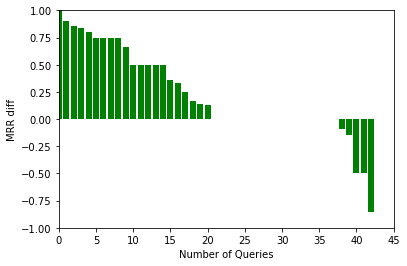

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.bar(range(len(diff_per_query_mrr)),diff_per_query_mrr, color='g')
plt.xlabel("Number of Queries")
plt.ylabel("MRR diff")
plt.xlim([0,45])
plt.ylim([-1,1])
plt.savefig('per_query_mrr_analysis_ms_marco.png', bbox_inches='tight')
plt.show()

## Compute Per Query MRR T=2

In [48]:
bm25_mrr_values = []
bert_mrr_values = []

query_ids = get_query_ids(new_qrels2_df)
for query_id in tqdm_notebook(query_ids):
    qrels_query_subset = new_qrels2_df[new_qrels2_df['query_id'] == query_id]
    bm25_subset = bm25_df[bm25_df['query_id'] == query_id].copy()
    bert_subset = bert_df[bert_df['query_id'] == query_id].copy()
    
    top_n_bm25_ranking = get_top_n_ranking(bm25_subset,'bm25_rank',N)
    top_n_bert_ranking = get_top_n_ranking(bert_subset,'bert_rank',N)
    
    relevant_passages = get_passage_ids(qrels_query_subset)
    
    bm25_mrr_values.append(compute_mrr(relevant_passages,top_n_bm25_ranking,"bm25",N))
    bert_mrr_values.append(compute_mrr(relevant_passages,top_n_bert_ranking,"bert",N))

c:\users\tomjg\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [49]:
diff_per_query_mrr = []
for index, bert_mrr in enumerate(bert_mrr_values):
    bm25_mrr = bm25_mrr_values[index]
    diff = bert_mrr - bm25_mrr
    diff_per_query_mrr.append(diff)
diff_per_query_mrr = sorted(diff_per_query_mrr,reverse=True)

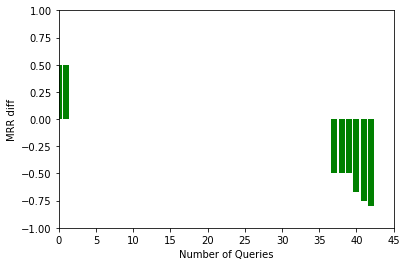

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.bar(range(len(diff_per_query_mrr)),diff_per_query_mrr, color='g')
plt.xlabel("Number of Queries")
plt.ylabel("MRR diff")
plt.xlim([0,45])
plt.ylim([-1,1])
plt.savefig('per_query_mrr_analysis_t2.png', bbox_inches='tight')
plt.show()

In [41]:
from collections import Counter
Counter(diff_per_query_mrr)

Counter({-0.8: 1, -0.75: 1, -0.6666666666666667: 1, -0.5: 3, 0.0: 35, 0.5: 2})

In [42]:
35/43

0.813953488372093

## Compute Per Query MRR T=3

In [51]:
bm25_mrr_values = []
bert_mrr_values = []

query_ids = get_query_ids(new_qrels3_df)
for query_id in tqdm_notebook(query_ids):
    qrels_query_subset = new_qrels3_df[new_qrels3_df['query_id'] == query_id]
    bm25_subset = bm25_df[bm25_df['query_id'] == query_id].copy()
    bert_subset = bert_df[bert_df['query_id'] == query_id].copy()
    
    top_n_bm25_ranking = get_top_n_ranking(bm25_subset,'bm25_rank',N)
    top_n_bert_ranking = get_top_n_ranking(bert_subset,'bert_rank',N)
    
    relevant_passages = get_passage_ids(qrels_query_subset)
    
    bm25_mrr_values.append(compute_mrr(relevant_passages,top_n_bm25_ranking,"bm25",N))
    bert_mrr_values.append(compute_mrr(relevant_passages,top_n_bert_ranking,"bert",N))

c:\users\tomjg\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [52]:
diff_per_query_mrr = []
for index, bert_mrr in enumerate(bert_mrr_values):
    bm25_mrr = bm25_mrr_values[index]
    diff = bert_mrr - bm25_mrr
    diff_per_query_mrr.append(diff)
diff_per_query_mrr = sorted(diff_per_query_mrr,reverse=True)

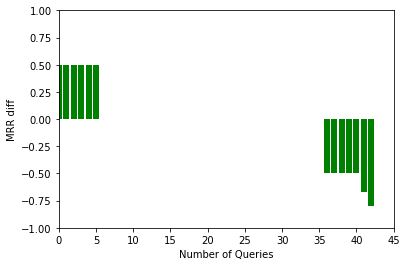

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.bar(range(len(diff_per_query_mrr)),diff_per_query_mrr, color='g')
plt.xlabel("Number of Queries")
plt.ylabel("MRR diff")
plt.xlim([0,45])
plt.ylim([-1,1])
plt.savefig('per_query_mrr_analysis_t3.png', bbox_inches='tight')
plt.show()

In [46]:
from collections import Counter
Counter(diff_per_query_mrr)

Counter({-0.8: 1, -0.6666666666666667: 1, -0.5: 5, 0.0: 30, 0.5: 6})

In [47]:
30/43

0.6976744186046512